# **Brain Cancer MRI Colorized Dataset**
https://www.kaggle.com/datasets/shuvokumarbasakbd/brain-cancer-mri-colorized-dataset/data

# **脳腫瘍の分類とマスク画像のセグメンテーションをマルチタスクで学習する**
## → 腫瘍に、より注目させるためにマスク画像を再構成させる

##  `brain_tumor`, `brain_glioma`,`brain_menin` について
これらははすべて脳腫瘍（brain tumor）に関連する用語ですが、それぞれ意味が異なる。


###  **brain tumor（脳腫瘍）**

* **定義**: 脳内にできる腫瘍（良性または悪性）の総称。
* **分類**: 発生部位や細胞の種類によって以下のように分類される：

  * 原発性脳腫瘍（脳内で発生）
  * 転移性脳腫瘍（他の部位から転移）


###  **glioma（グリオーマ / 神経膠腫）**

* **定義**: 神経膠細胞（グリア細胞）から発生する腫瘍。**脳腫瘍の中で最も一般的なタイプの一つ**。
* **主な種類**:

  * **astrocytoma（星状膠腫）**
  * **oligodendroglioma（乏突起膠腫）**
  * **ependymoma（上衣腫）**
* **悪性度分類（WHOグレード）**:

  * Grade I～IV（IVが最も悪性）
  * **glioblastoma（グリオブラストーマ）**　はGrade IVで、極めて進行が早く予後不良。


###  **meningioma（髄膜腫）**

* **定義**: 脳を包む膜（髄膜）から発生する腫瘍。
* **特徴**:

  * 多くが**良性**（WHOグレードI）
  * ゆっくり成長する
  * 外科的に切除可能な場合が多い
  * 発生は中高年に多く、女性にやや多い傾向
* **注意**: menin ではなく **meningioma** が正しい名称。


## **まとめ**

* **class0** : `brain_glioma`: 神経膠腫に分類される腫瘍
* **class1** : `brain_menin`（おそらく meningioma の略）: 髄膜腫
* **class2** : `brain_tumor`: その他の脳腫瘍（例：medulloblastoma、pituitary tumor など）

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## シード固定

In [2]:
os.environ["PYTHONHASHSEED"] = "42"

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

## セグメンテーションマスクの前処理

In [3]:
mask_path = r"C:\Users\PC_User\Python\Kaggle\Brain_Cancer_MRI_Colorized_Dataset\archive\data\brain_glioma\Interactive_Segmentation\brain_glioma_0017_13.jpg"
mask = np.array(Image.open(mask_path).convert("L")) / 255

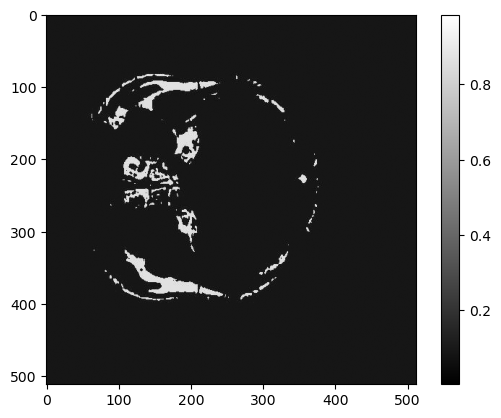

In [4]:
plt.imshow(mask, cmap='gray')
plt.colorbar();

#### セグメンテーションマスクが連続的であるため、閾値 0.5 で二値化する。

## Dataset & DataLoader

In [5]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [6]:
class ColorizedPairDatasetByID(Dataset):
    def __init__(self, base_dir, class_list, processing_types, transform=None):

        self.image_paths = []
        self.mask_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_list)}

        image_type, mask_type = processing_types

        for cls_name in class_list:
            class_path = os.path.join(base_dir, cls_name)
            image_pattern = os.path.join(class_path, image_type, "*.*")
            mask_pattern = os.path.join(class_path, mask_type, "*.*")

            image_files = glob.glob(image_pattern)
            mask_files = glob.glob(mask_pattern)

            image_id_map = {}
            mask_id_map = {}

            for f in image_files:
                fname = os.path.basename(f)
                parts = fname.split('_')
                if len(parts) < 4:
                    continue
                image_id = '_'.join(parts[:3])
                image_id_map[image_id] = f

            for f in mask_files:
                fname = os.path.basename(f)
                parts = fname.split('_')
                if len(parts) < 4:
                    continue
                image_id = '_'.join(parts[:3])
                mask_id_map[image_id] = f

            common_ids = set(image_id_map.keys()) & set(mask_id_map.keys())

            for image_id in common_ids:
                self.image_paths.append(image_id_map[image_id])
                self.mask_paths.append(mask_id_map[image_id])
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        label = self.labels[idx]
        
        # PIL -> NumPy array
        img = np.array(Image.open(img_path).convert("RGB")) / 255
        mask = np.array(Image.open(mask_path).convert("L")) / 255

        # 0.5 の閾値で2値化
        mask = (mask > 0.5).astype(np.float32)
    
        # albumentationsでaugment
        augmented = self.transform(image=img, mask=mask)
        img = augmented['image'].float()
        mask = augmented['mask'].float()
        label = torch.tensor(label).long()
    
        return img, mask, label

In [7]:
data_dirs = r"C:\Users\PC_User\Python\Kaggle\Brain_Cancer_MRI_Colorized_Dataset\archive\data"
class_list = os.listdir(data_dirs)
processing_types = ['Alpha_Blending', 'Interactive_Segmentation']

base_dataset = ColorizedPairDatasetByID(data_dirs, class_list, processing_types, transform=None)

total_size = len(base_dataset)
train_size = int(total_size * 0.6)
valid_size = int(total_size * 0.2)
test_size = total_size - train_size - valid_size

# データセット分割
train_indices, valid_indices, test_indices = torch.utils.data.random_split(
    range(total_size),
    [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# transform 適用のためのラップ
train_dataset = Subset(ColorizedPairDatasetByID(data_dirs, class_list, processing_types, transform=train_transform), train_indices)
valid_dataset = Subset(ColorizedPairDatasetByID(data_dirs, class_list, processing_types, transform=valid_transform), valid_indices)
test_dataset = Subset(ColorizedPairDatasetByID(data_dirs, class_list, processing_types, transform=valid_transform), test_indices)

In [8]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## First batch images

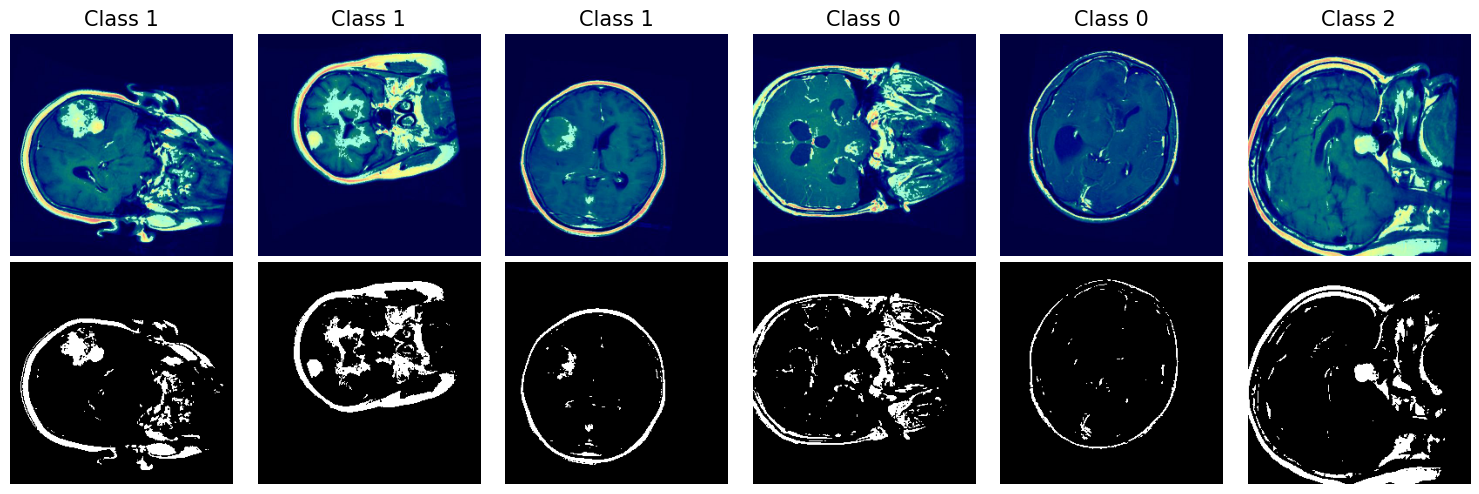

In [9]:
for batch in train_loader:
    images, masks, labels = batch
    break

images_np = images.permute(0, 2, 3, 1).cpu().numpy() 
masks_np = masks.cpu().numpy()

fig, ax = plt.subplots(2, 6, figsize=(15, 5))
for i in range(6):
    ax[0, i].imshow(images_np[i])
    ax[0, i].set_title(f'Class {labels[i]}', fontsize=15)
    ax[0, i].axis('off')
    ax[1, i].imshow(masks_np[i], cmap='gray')
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

# モデルの設計

In [10]:
from torchvision.models import convnext_tiny

ConvNext = convnext_tiny(pretrained=True)
ConvNext_Encoder = nn.Sequential(*list(ConvNext.children())[:-2]) 

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
class ConvTransposeDecoder(nn.Module):
    def __init__(self, in_channels=768, out_channels=1):
        super(ConvTransposeDecoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 512, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.InstanceNorm2d(512, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 256x256
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, out_channels, kernel_size=1)  # 1x1 conv でチャネル調整（出力: 1）
        )

    def forward(self, x):
        return self.decoder(x)

In [12]:
class SimpleClassifier(nn.Module):
    def __init__(self, in_channels=768, num_classes=3):
        super(SimpleClassifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # (B, C, 8, 8) → (B, C, 1, 1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.pool(x)         # Global Average Pooling
        x = self.classifier(x)
        return x

In [13]:
class MultitaskModel(nn.Module):
    def __init__(self, num_classes):
        super(MultitaskModel, self).__init__()
        self.encoder = ConvNext_Encoder
        self.decoder = ConvTransposeDecoder()
        self.classifier = SimpleClassifier(768, num_classes)

    def forward(self, x):
        bottleneck = self.encoder(x) 
        x_recon_logits = self.decoder(bottleneck)
        cls_logits = self.classifier(bottleneck)
        return x_recon_logits, cls_logits

出力形状の確認

In [14]:
model = MultitaskModel(num_classes=3)
model = model.to('cuda')
model.eval()
dummy_input = torch.randn(1, 3, 256, 256).to('cuda')
with torch.no_grad():
    x_recon_logits, cls_logits = model(dummy_input)
print(x_recon_logits.shape, cls_logits.shape)

torch.Size([1, 1, 256, 256]) torch.Size([1, 3])


## 損失関数：多タスク損失の不確かさによる重み付け（Kendall et al., CVPR 2018）

2つの損失関数を同時に最小化したい：

* $\mathcal{L}_1(W)$：セグメンテーションなど
* $\mathcal{L}_2(W)$：分類など

### 損失の合計（不確かさ重み付き）：

$$
\mathcal{L}(W, \sigma_1, \sigma_2) = 
\frac{1}{2\sigma_1^2} \mathcal{L}_1(W) + 
\frac{1}{2\sigma_2^2} \mathcal{L}_2(W) + 
\log \sigma_1 + \log \sigma_2
$$

ここで：

* $\sigma_1, \sigma_2$ はそれぞれのタスクの **観測ノイズに基づく不確かさ**（学習可能なパラメータ）
* $W$ はモデルのパラメータ

In [15]:
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):

        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return BCE + dice_loss


class LossFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_sigma_seg = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))

        self.seg = DiceBCELoss()
        self.cls = nn.CrossEntropyLoss()

    def forward(self, x_recon_logits, seg_targets, cls_logits, cls_targets):
        Seg = self.seg(x_recon_logits, seg_targets)
        Cls = self.cls(cls_logits, cls_targets)

        weighted_loss = (
            0.5 * torch.exp(-self.log_sigma_seg) * Seg + self.log_sigma_seg +
            0.5 * torch.exp(-self.log_sigma_cls) * Cls + self.log_sigma_cls
        )
        return weighted_loss, Seg, Cls

# 訓練

In [16]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_seg_loss = 0
    train_cls_loss = 0
    for imgs, seg_targets, cls_targets in loader:
        imgs, seg_targets, cls_targets = imgs.to('cuda'), seg_targets.to('cuda'), cls_targets.to('cuda')
        optimizer.zero_grad()
        x_recon_logits, cls_logits = model(imgs)
        loss, seg_loss, cls_loss = criterion(x_recon_logits, seg_targets, cls_logits, cls_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_seg_loss += seg_loss.item()
        train_cls_loss += cls_loss.item()
    return train_loss / len(loader), train_seg_loss / len(loader), train_cls_loss / len(loader)

In [17]:
def valid_one_epoch(model, loader, criterion):
    model.eval()
    valid_loss = 0
    valid_seg_loss = 0
    valid_cls_loss = 0
    with torch.no_grad():
        for imgs, seg_targets, cls_targets in loader:
            imgs, seg_targets, cls_targets = imgs.to('cuda'), seg_targets.to('cuda'), cls_targets.to('cuda')
            x_recon_logits, cls_logits = model(imgs)
            loss, seg_loss, cls_loss = criterion(x_recon_logits, seg_targets, cls_logits, cls_targets)
            valid_loss += loss.item()
            valid_seg_loss += seg_loss.item()
            valid_cls_loss += cls_loss.item()
    return valid_loss / len(loader), valid_seg_loss / len(loader), valid_cls_loss / len(loader)

In [18]:
num_epochs = 100
patience = 3
criterion = LossFunction()
optimizer = torch.optim.AdamW(list(model.parameters()) + list(criterion.parameters()), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

In [19]:
best_val_loss = float('inf')
history = {"train_loss": [], "train_seg_loss": [], "train_cls_loss": [],
           "valid_loss": [], "valid_seg_loss": [], "valid_cls_loss": []}

for epoch in range(1, num_epochs + 1):
          
    train_loss, train_seg_loss, train_cls_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    valid_loss, valid_seg_loss, valid_cls_loss = valid_one_epoch(model, valid_loader, criterion)

    scheduler.step(valid_loss)

    history["train_loss"].append(train_loss)
    history["train_seg_loss"].append(train_seg_loss)
    history["train_cls_loss"].append(train_cls_loss)
    history["valid_loss"].append(valid_loss)
    history["valid_seg_loss"].append(valid_seg_loss)
    history["valid_cls_loss"].append(valid_cls_loss)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, f'best_model.pth')
        if epoch % 10 == 0:
            print(f"[{epoch:02d}] Best model saved with validation loss: {best_val_loss:.5f}\n")
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % 10 == 0:
        print(f"[{epoch:02d}] Train Loss: {train_loss:.5f} | Train DiceBCE: {train_seg_loss:.5f} | Train CrossEntropy: {train_cls_loss:.5f}")
        print(f"[{epoch:02d}] Valid Loss: {valid_loss:.5f} | Valid DiceBCE: {valid_seg_loss:.5f} | Valid CrossEntropy: {valid_cls_loss:.5f}")
        print()

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

[10] Best model saved with validation loss: 0.10912

[10] Train Loss: 0.13060 | Train DiceBCE: 0.63811 | Train CrossEntropy: 0.01724
[10] Valid Loss: 0.10912 | Valid DiceBCE: 0.61259 | Valid CrossEntropy: 0.02326

[20] Best model saved with validation loss: -0.24022

[20] Train Loss: -0.23769 | Train DiceBCE: 0.36979 | Train CrossEntropy: 0.02197
[20] Valid Loss: -0.24022 | Valid DiceBCE: 0.35908 | Valid CrossEntropy: 0.04607

[30] Train Loss: -0.51051 | Train DiceBCE: 0.28390 | Train CrossEntropy: 0.01893
[30] Valid Loss: -0.42395 | Valid DiceBCE: 0.28307 | Valid CrossEntropy: 0.15667

[40] Train Loss: -0.75666 | Train DiceBCE: 0.24444 | Train CrossEntropy: 0.01047
[40] Valid Loss: -0.65930 | Valid DiceBCE: 0.24501 | Valid CrossEntropy: 0.14536

[50] Best model saved with validation loss: -0.95169

[50] Train Loss: -0.97586 | Train DiceBCE: 0.22721 | Train CrossEntropy: 0.01198
[50] Valid Loss: -0.95169 | Valid DiceBCE: 0.23009 | Valid CrossEntropy: 0.04756

[60] Best model saved with

## Training History

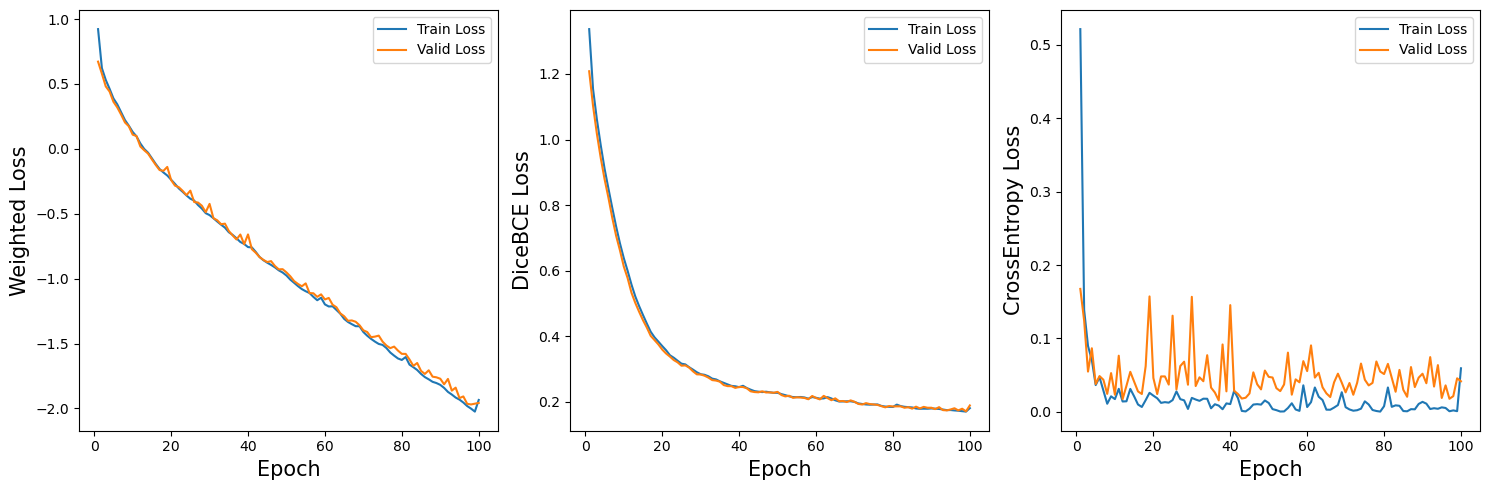

In [20]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["valid_loss"], label='Valid Loss')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Weighted Loss', fontsize=15)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_seg_loss"], label='Train Loss')
    plt.plot(epochs, history["valid_seg_loss"], label='Valid Loss')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('DiceBCE Loss', fontsize=15)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_cls_loss"], label='Train Loss')
    plt.plot(epochs, history["valid_cls_loss"], label='Valid Loss')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('CrossEntropy Loss', fontsize=15)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

# テスト

In [21]:
model = MultitaskModel(num_classes=3).to('cuda')
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_imgs = []
all_recon_mask = []
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, seg_targets, cls_targets in test_loader:
        imgs, seg_targets, cls_targets = imgs.to('cuda'), seg_targets.to('cuda'), cls_targets.to('cuda')
        
        x_recon_logits, cls_logits = model(imgs)

        preds = torch.argmax(cls_logits, dim=1)

        all_imgs.append(imgs.permute(0, 2, 3, 1).cpu().numpy())
        all_recon_mask.append(x_recon_logits.squeeze(1).cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(cls_targets.cpu().numpy())

all_imgs = np.concatenate(all_imgs, axis=0) 
all_recon_mask = np.concatenate(all_recon_mask, axis=0) 
all_preds = np.concatenate(all_preds, axis=0) 
all_labels = np.concatenate(all_labels, axis=0)   

## 精度の確認

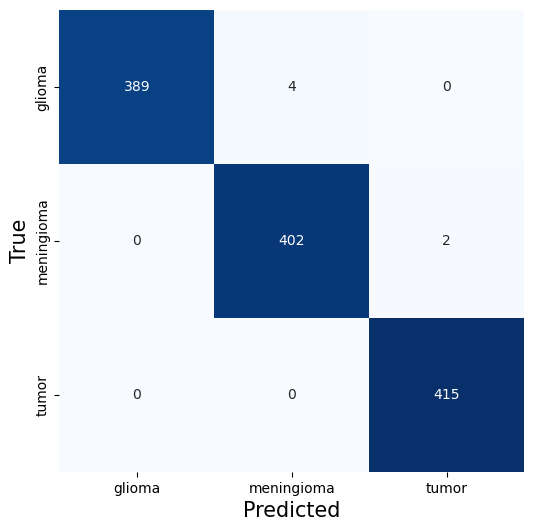

              precision    recall  f1-score   support

      glioma    1.00000   0.98982   0.99488       393
  meningioma    0.99015   0.99505   0.99259       404
       tumor    0.99520   1.00000   0.99760       415

    accuracy                        0.99505      1212
   macro avg    0.99512   0.99496   0.99502      1212
weighted avg    0.99507   0.99505   0.99505      1212



In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(all_labels, all_preds)
class_names = ['glioma', 'meningioma', 'tumor']

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()
print(classification_report(all_labels, all_preds, target_names=class_names, digits=5))

## 再構成したセグメンテーションマスクの可視化

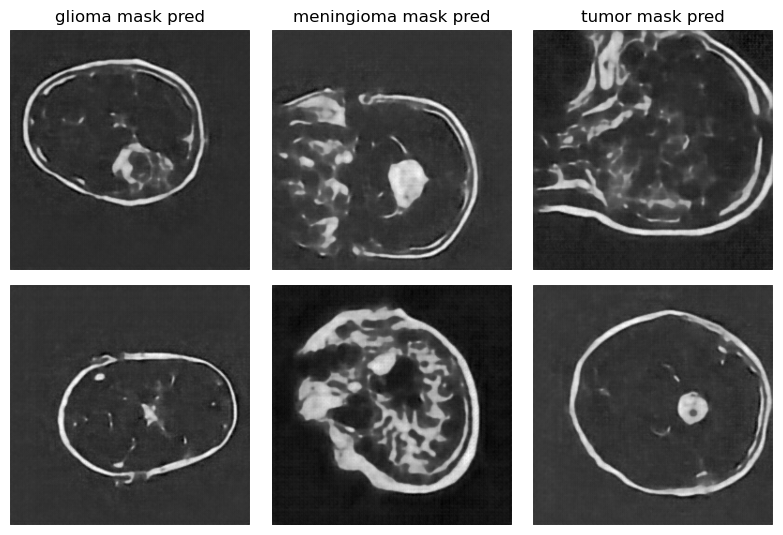

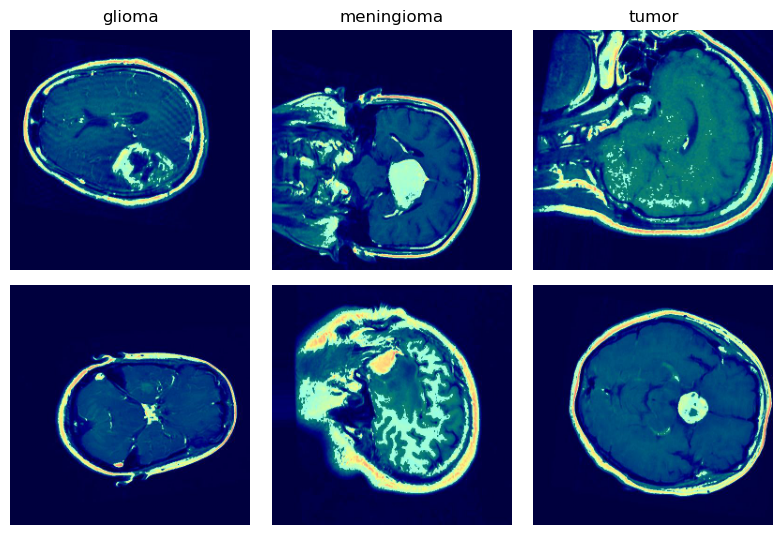

In [23]:
classes = np.unique(all_labels)
plt.figure(figsize=(8, 8))

for col, cls in enumerate(classes):
    idxs = np.where(all_labels == cls)[0][:2]
    for row, idx in enumerate(idxs):
        plt_idx = row * len(classes) + col + 1
        plt.subplot(3, len(classes), plt_idx)
        plt.imshow(all_recon_mask[idx].squeeze(), cmap='gray')
        if row == 0:
            plt.title(f'{class_names[cls]} mask pred')
        plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))

for col, cls in enumerate(classes):
    idxs = np.where(all_labels == cls)[0][:2]
    for row, idx in enumerate(idxs):
        plt_idx = row * len(classes) + col + 1
        plt.subplot(3, len(classes), plt_idx)
        plt.imshow(all_imgs[idx])
        if row == 0:
            plt.title(class_names[cls])
        plt.axis('off')

plt.tight_layout()
plt.show()

# **まとめ**

### 🔍 **なぜマルチタスクで分類精度が上がる可能性があるのか？**
**今回は特に比較検証をしていないため、分類精度が上がったかどうかは不明だが、かなり高精度で分類できている。**

#### ✅ **1. 表現学習の誘導効果**

* セグメンテーションタスクでは、空間的・局所的な特徴を詳細に捉える必要がある。
* 分類タスクでは、グローバルな特徴や全体的なパターンを捉えることが重要。
* この2つのタスクを共有のエンコーダで同時に解くことで、「局所 + 大域」両面に強い特徴表現が学習される。

  * → 分類にとっても有利な表現になる可能性が高い。

#### ✅ **2. 正則化効果（Regularization）**

* 複数のタスクを同時に学習することで、ある1つのタスクに過剰適合（過学習）しづらくなる。
* 結果的に汎化性能（テストデータへの適応力）が向上する。

#### ✅ **3. 補助信号による学習の安定化**

* たとえば分類ラベルが少ない場合でも、セグメンテーションのピクセル単位のラベル情報が豊富に存在し、学習が安定する。
* これは**セミ教師あり学習的な効果**にも近い。

#### ✅ **4. 関連タスク間の帰納バイアスの共有**

* セグメンテーションと分類は「対象の位置や形状に意味がある」という点で密接に関連している。
* 共通の構造を学習することで、どちらのタスクにも有益な表現が得られる。

---

### 🧠 実際の例

今回のケース（脳腫瘍画像の分類とセグメンテーション）でも：

* **分類だけ**で学習すると「腫瘍の位置や形を考慮しない」特徴に偏る可能性がある。
* **分類 + セグメンテーション**だと、腫瘍の境界や広がりも強く意識された特徴になり、より判別しやすくなるという理屈。

---

### 💡補足

ただし、タスク間に矛盾があったり、片方が極端に難しい場合は逆効果（**負の転移：Negative Transfer**）も起こり得るため、タスク設計や損失の重みバランスが重要である。